In [1]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask
import numpy as np
from lonboard import viz
import h3

In [ ]:
# Load country boundaries (Canada)
gdf = gpd.read_file('data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
canada_gdf = gdf[gdf['NAME'] == 'Canada']

In [2]:
gdf = gpd.read_file('data/lpr_000b16a_e/lpr_000b16a_e.shp')
quebec_gdf = gdf[gdf['PRENAME'] == 'Quebec']

In [7]:
def plot_raster_data(raster_data, bounds):
    fig, ax = plt.subplots(figsize=(10, 10))
    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    im = ax.imshow(
        raster_data, 
        cmap='viridis', 
        extent=extent,
    )
    ax.set_title('Canada Climate Data')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add a colorbar to show the temperature gradient
    cbar = plt.colorbar(im, ax=ax, orientation='vertical')
    cbar.set_label('Temperature')

    plt.show()

def open_tif(file_name):
    with rasterio.open(file_name) as src:
        raster_data = src.read(1, masked=True)  # read the first band
        affine = src.transform
        raster_data = np.where(raster_data == raster_data.min(), np.nan, raster_data)
        bounds = src.bounds
    return raster_data, bounds

def visualize_tif(file_name):
    raster_data, bounds = open_tif(file_name)
    plot_raster_data(raster_data, bounds)

In [8]:
raster_data, bounds = open_tif('data\worldClim\clipped_wc2.1_30s_bio_1.tif')
plot_raster_data(raster_data, bounds)

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_35912/1589462537.py:1: SyntaxWarning: invalid escape sequence '\w'
  raster_data, bounds = open_tif('data\worldClim\clipped_wc2.1_30s_bio_1.tif')
/tmp/ipykernel_35912/1589462537.py:1: SyntaxWarning: invalid escape sequence '\w'
  raster_data, bounds = open_tif('data\worldClim\clipped_wc2.1_30s_bio_1.tif')


RasterioIOError: data\worldClim\clipped_wc2.1_30s_bio_1.tif: No such file or directory

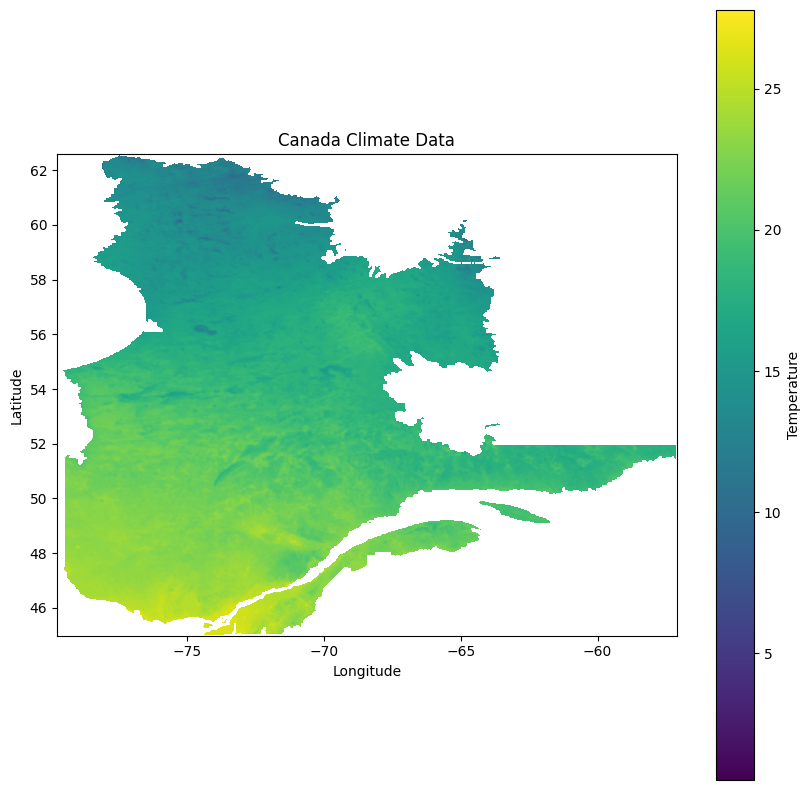

In [16]:
visualize_tif("data\worldClim\clipped_wc2.1_30s_bio_5.tif")

In [15]:
import pandas as pd

import pyarrow.parquet as pq

parquet_file = pq.ParquetFile('data/atlas_public_2024-07-16.parquet')
batches = []
for i, batch in enumerate(parquet_file.iter_batches(batch_size=1000)):
    if i >= 10:
        break
    batches.append(batch.to_pandas())

df = pd.concat(batches, ignore_index=True)
print(df)

         valid_scientific_name  observation_value observation_type  \
0        Myriophyllum spicatum                1.0       occurrence   
1       Impatiens glandulifera                1.0       occurrence   
2     Heracleum mantegazzianum                1.0       occurrence   
3            Popillia japonica              200.0        abundance   
4        Myriophyllum spicatum                1.0       occurrence   
...                        ...                ...              ...   
9995            Morus bassanus                1.0         presence   
9996            Morus bassanus                1.0         presence   
9997            Morus bassanus                1.0         presence   
9998                Uria aalge                1.0         presence   
9999     Oceanodroma leucorhoa                1.0         presence   

      effort_sampling_value effort_sampling_method effort_sampling_unit  \
0                       NaN                   None                 None   
1        

In [16]:
from shapely.geometry import Point

# Create a GeoDataFrame from the DataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

if geo_df.crs is None:
    geo_df.set_crs(epsg=4326, inplace=True)

print(geo_df.head())

      valid_scientific_name  observation_value observation_type  \
0     Myriophyllum spicatum                1.0       occurrence   
1    Impatiens glandulifera                1.0       occurrence   
2  Heracleum mantegazzianum                1.0       occurrence   
3         Popillia japonica              200.0        abundance   
4     Myriophyllum spicatum                1.0       occurrence   

   effort_sampling_value effort_sampling_method effort_sampling_unit  \
0                    NaN                   None                 None   
1                    NaN                   None                 None   
2                    NaN                   None                 None   
3                    NaN                   None                 None   
4                    NaN                   None                 None   

   longitude  latitude coordinate_uncertainty coordinate_uncertainty_unit  \
0   -75.8228   46.4450                   None                        None   
1   -73.54

NameError: name 'bounds' is not defined

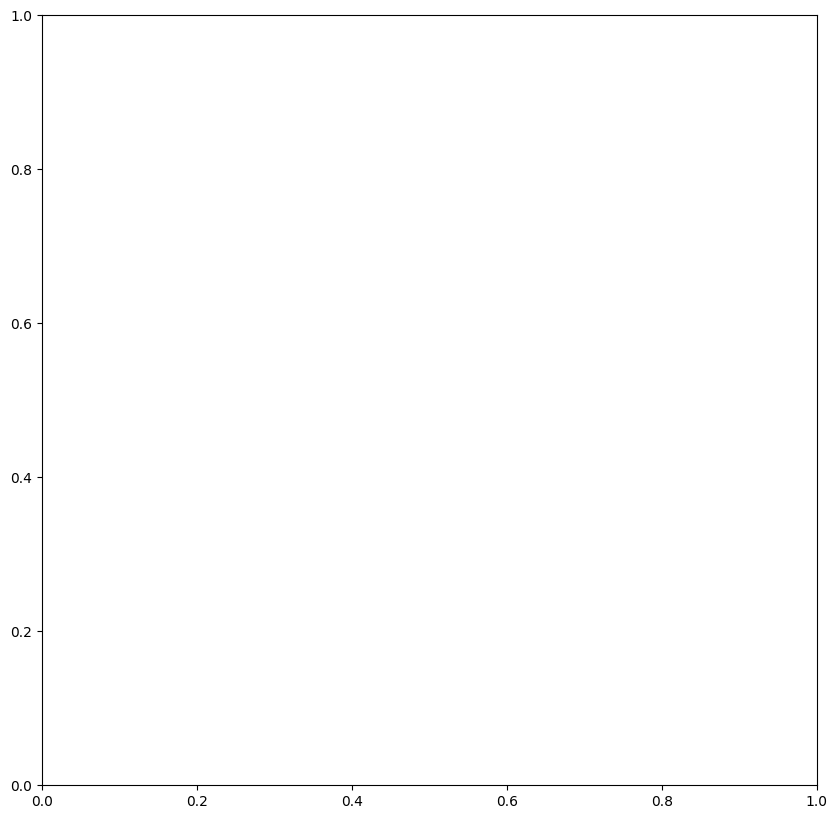

In [5]:
import geopandas as gpd
from shapely.geometry import Point

# Create a GeoDataFrame from the DataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
im = ax.imshow(
    raster_data, 
    cmap='viridis', 
    extent=extent,
)
ax.set_title('Canada Climate Data')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# base = world.plot(ax=ax, color='white', edgecolor='black')

geo_df.plot(ax=ax, marker='o', color='blue', markersize=5)
plt.title('Observations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [6]:
# Ensure the CRS is set to WGS84
if geo_df.crs is None:
    geo_df.set_crs(epsg=4326, inplace=True)

viz(geo_df)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [17]:
H3_res = 5
def geo_to_h3(row):
  return h3.latlng_to_cell(lat=row.latitude,lng=row.longitude, res=H3_res)

geo_df['h3_cell'] = geo_df.apply(geo_to_h3, axis=1)

In [18]:
# Calculate the frequency count of h3_cell
h3_distribution = geo_df['h3_cell'].value_counts()

# Map the counts to the geo_df DataFrame
geo_df['count'] = geo_df['h3_cell'].map(h3_distribution)
print(geo_df[['h3_cell', 'count']].head())

           h3_cell  count
0  852b800bfffffff      2
1  852baacbfffffff     93
2  852ba86bfffffff     80
3  852bac4bfffffff    107
4  852b806ffffffff      1


In [24]:
from shapely.geometry import Polygon

def add_geometry(row):
  points = h3.cell_to_boundary(row['h3_cell'])
  flipped = tuple(coord[::-1] for coord in points)
  return Polygon(flipped)

geo_df['geometry'] = (geo_df.apply(add_geometry,axis=1))

In [23]:
geo_df.sort_values('count',ascending=False)

,valid_scientific_name,observation_value,observation_type,effort_sampling_value,effort_sampling_method,effort_sampling_unit,longitude,latitude,coordinate_uncertainty,coordinate_uncertainty_unit,...,dataset_creator,dataset_publisher,license,doi,within_quebec,geom,geom_bbox,geometry,h3_cell,count
837,Reynoutria japonica,1.0,occurrence,NaN,None,None,-72.7092,45.4137,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00\xaf\x94e\x88c-R\xc0w-!\...,"{'xmin': -72.7092056274414, 'ymin': 45.4136962...","POLYGON ((45.49166 -72.79392, 45.44461 -72.909...",852baaabfffffff,450
121,Alliaria petiolata,1.0,occurrence,NaN,None,None,-71.3165,46.8094,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00\xc7K7\x89A\xd4Q\xc0\xf2...,"{'xmin': -71.3165054321289, 'ymin': 46.8093986...","POLYGON ((46.87227 -71.37755, 46.82623 -71.497...",852bac5bfffffff,440
66,Glyceria maxima,1.0,occurrence,NaN,None,None,-72.3851,46.4174,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,"b'\x01\x01\x00\x00\x00""lxz\xa5\x18R\xc0\xda\xa...","{'xmin': -72.38510131835938, 'ymin': 46.417392...","POLYGON ((46.45381 -72.45211, 46.40676 -72.570...",852bae0ffffffff,313
54,Reynoutria japonica,1.0,occurrence,NaN,None,None,-71.1748,46.8586,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00\xd0\xd5V\xec/\xcbQ\xc0=...,"{'xmin': -71.1748046875, 'ymin': 46.8585929870...","POLYGON ((47.01016 -71.2551, 46.9642 -71.37593...",852ba127fffffff,300
1162,Heracleum mantegazzianum,1.0,abundance,NaN,None,None,-72.5885,46.3135,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00\x8bl\xe7\xfb\xa9%R\xc0\...,"{'xmin': -72.5885009765625, 'ymin': 46.3134994...","POLYGON ((46.4512 -72.68941, 46.4039 -72.80738...",852bae73fffffff,265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,Myriophyllum spicatum,1.0,occurrence,NaN,None,None,-75.5790,46.5557,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00\x93\x18\x04V\x0e\xe5R\x...,"{'xmin': -75.5790023803711, 'ymin': 46.5556983...","POLYGON ((46.65659 -75.55782, 46.60625 -75.673...",852b8013fffffff,1
9888,Cepphus grylle,1.0,presence,NaN,None,None,-68.0000,49.0000,None,None,...,OBIS,Biotime,CC-by-NC,https://doi.org/10.1111/geb.12729,True,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...,"{'xmin': -68.0, 'ymin': 49.0, 'xmax': -68.0, '...","POLYGON ((49.04699 -68.07072, 49.00408 -68.200...",850e492bfffffff,1
44,Heracleum mantegazzianum,150.0,abundance,NaN,None,None,-69.8669,46.8966,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00\xc19#J{wQ\xc0\xfb\xcb\x...,"{'xmin': -69.86690521240234, 'ymin': 46.896598...","POLYGON ((46.99997 -69.8166, 46.95558 -69.9386...",852b122ffffffff,1
39,Reynoutria japonica,1.0,occurrence,NaN,None,None,-74.9981,46.2939,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00\xce\x88\xd2\xde\xe0\xbf...,"{'xmin': -74.99810028076172, 'ymin': 46.293899...","POLYGON ((46.39809 -75.06237, 46.34836 -75.177...",852b80a3fffffff,1


In [25]:
geo_df = geo_df.drop_duplicates(subset=['h3_cell'])

In [35]:
geo_df

,valid_scientific_name,observation_value,observation_type,effort_sampling_value,effort_sampling_method,effort_sampling_unit,longitude,latitude,coordinate_uncertainty,coordinate_uncertainty_unit,...,dataset_creator,dataset_publisher,license,doi,within_quebec,geom,geom_bbox,geometry,h3_cell,count
0,Myriophyllum spicatum,1.0,occurrence,NaN,None,None,-75.8228,46.4450,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00\x86\xc9T\xc1\xa8\xf4R\x...,"{'xmin': -75.82280731201172, 'ymin': 46.444999...","POLYGON ((46.50529 -75.90368, 46.45466 -76.018...",852b800bfffffff,2
1,Impatiens glandulifera,1.0,occurrence,NaN,None,None,-73.5475,45.9357,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00\xd7\xa3p=\ncR\xc0\x00o\...,"{'xmin': -73.54750061035156, 'ymin': 45.935699...","POLYGON ((46.02656 -73.50734, 45.97858 -73.623...",852baacbfffffff,93
2,Heracleum mantegazzianum,1.0,occurrence,NaN,None,None,-72.2417,45.2933,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00]\xdcF\x03x\x0fR\xc0Z\xf...,"{'xmin': -72.24170684814453, 'ymin': 45.293292...","POLYGON ((45.36191 -72.21319, 45.31551 -72.328...",852ba86bfffffff,80
3,Popillia japonica,200.0,abundance,NaN,None,None,-71.6025,46.6584,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x00\xc3\xf5(\\\x8f\xe6Q\xc0...,"{'xmin': -71.60250091552734, 'ymin': 46.658393...","POLYGON ((46.73439 -71.49925, 46.68826 -71.619...",852bac4bfffffff,107
4,Myriophyllum spicatum,1.0,occurrence,NaN,None,None,-76.1305,45.9536,None,None,...,Sentinelle/MELCC,Sentinelle/MELCC,CC0 1.0,,True,b'\x01\x01\x00\x00\x001\x08\xac\x1cZ\x08S\xc0\...,"{'xmin': -76.13050079345703, 'ymin': 45.953594...","POLYGON ((46.07896 -76.22177, 46.02821 -76.335...",852b806ffffffff,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9782,Larus argentatus,1.0,presence,NaN,None,None,-67.6667,48.9333,None,None,...,OBIS,Biotime,CC-by-NC,https://doi.org/10.1111/geb.12729,True,b'\x01\x01\x00\x00\x00\x91\x0fz6\xab\xeaP\xc0\...,"{'xmin': -67.66670227050781, 'ymin': 48.933292...","POLYGON ((49.03111 -67.57079, 48.98878 -67.700...",850e4937fffffff,2
9888,Cepphus grylle,1.0,presence,NaN,None,None,-68.0000,49.0000,None,None,...,OBIS,Biotime,CC-by-NC,https://doi.org/10.1111/geb.12729,True,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...,"{'xmin': -68.0, 'ymin': 49.0, 'xmax': -68.0, '...","POLYGON ((49.04699 -68.07072, 49.00408 -68.200...",850e492bfffffff,1
9908,Larus argentatus,1.0,presence,NaN,None,None,-77.6167,59.6000,None,None,...,OBIS,Biotime,CC-by-NC,https://doi.org/10.1111/geb.12729,True,b'\x01\x01\x00\x00\x00]\xdcF\x03xgS\xc0\xcd\xc...,"{'xmin': -77.61670684814453, 'ymin': 59.599998...","POLYGON ((59.78112 -77.61201, 59.72547 -77.770...",850e0383fffffff,5
9936,Larus argentatus,1.0,presence,NaN,None,None,-61.0833,47.7000,None,None,...,OBIS,Biotime,CC-by-NC,https://doi.org/10.1111/geb.12729,True,b'\x01\x01\x00\x00\x00\xdf\xe0\x0b\x93\xa9\x8a...,"{'xmin': -61.08330154418945, 'ymin': 47.699993...","POLYGON ((47.797 -61.1499, 47.76238 -61.27957,...",852b206bfffffff,6


In [11]:
from sidecar import Sidecar
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_continuous_cmap

In [26]:
sidecar = Sidecar()

layer = PolygonLayer.from_geopandas(geo_df)
m = Map(layer, _height=800)
with sidecar:
    display(m)

In [27]:
display(m)

Map(custom_attribution='', layers=(PolygonLayer(table=arro3.core.Table
-----------
valid_scientific_name: Utf8…

In [28]:
species_counts = geo_df['count']

In [30]:
upper_bound = species_counts.max()
lower_bound = species_counts.min()
species_counts = (species_counts - lower_bound) / (upper_bound - lower_bound)

In [38]:
from palettable.cartocolors.diverging import Geyser_7_r

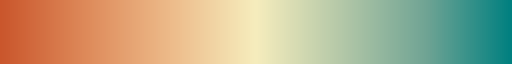

In [39]:
Geyser_7_r.mpl_colormap

In [40]:
layer.get_fill_color = apply_continuous_cmap(
    species_counts, Geyser_7_r, alpha=0.7
)